In [23]:
import numpy as np
np.random.seed(420)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
import sklearn.calibration
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

preProcFeatsnew = np.load('./redfeatbin.npy')
preProcLabelsnew = np.load('./processed.files/labelled/labelsnew.npy')

In [19]:
clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

In [20]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeatsnew,\
                                                            preProcLabelsnew, test_size=0.25, random_state=420)

y_test[y_test != 9] = 0
y_test[y_test == 9] = 1

y_train[y_train != 9] = 0
y_train[y_train == 9] = 1

valfrac = 0.25
print y_train.shape, X_train.shape
size = y_train.flatten().size
frac = int(0.25*size)

X_valid, y_valid = X_train[frac:size], y_train[frac:size]
X_train, y_train = X_train[:frac], y_train[:frac]
X_train_valid, y_train_valid = X_train[:frac], y_train[:frac]

(9298,) (9298, 204)


In [21]:
clf.fit(X_train_valid, y_train_valid)
probs = clf.predict_proba(X_test)
frac_pos, mean_pred_value = calibration_curve(y_test, probs[:,1], n_bins=6)

probs = clf.predict_proba(X_test)
iso_clf = sklearn.calibration.CalibratedClassifierCV(clf, method="isotonic", cv="prefit")
iso_clf.fit(X_train_valid, y_train_valid)
iso_probs = iso_clf.predict_proba(X_test)
frac_pos_iso, mean_pred_value_iso = calibration_curve(y_test, iso_probs[:,1], n_bins=6)

probs = clf.predict_proba(X_test)
sig_clf = sklearn.calibration.CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_train_valid, y_train_valid)
sig_probs = sig_clf.predict_proba(X_test)
frac_pos_sig, mean_pred_value_sig = calibration_curve(y_test, sig_probs[:,1], n_bins=6)

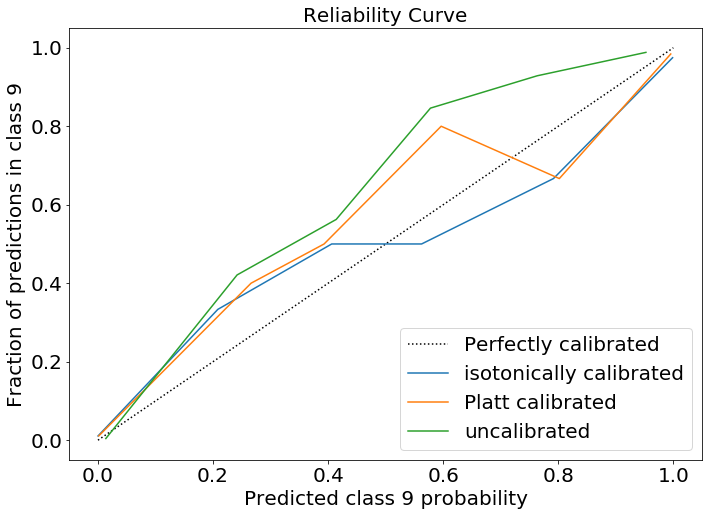

In [25]:
plt.figure(figsize=(10, 10))
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_pred_value_iso, frac_pos_iso, label="isotonically calibrated" )
ax1.plot(mean_pred_value_sig, frac_pos_sig,  label="Platt calibrated" )
ax1.plot(mean_pred_value, frac_pos, label="uncalibrated" )

ax1.set_ylabel("Fraction of predictions in class 9")
ax1.set_xlabel("Predicted class 9 probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curve')
plt.savefig('graphs/relcurvecal.png')

plt.tight_layout()
plt.show()